[Отчет находится здесь](https://github.com/sotvictory/ML-Practice/blob/main/CMC_5-6_sem/13_Spotify/ML_Spotify.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shap
import optuna
import pickle

from scipy.stats import ks_2samp, chisquare

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [2]:
PATH = '/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/sample_submission.csv
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/simple_pipeline.ipynb
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/train.csv
/kaggle/input/cmc-ml-spotify-tracks-popularity-prediction-2025/test.csv


In [3]:
train = pd.read_csv(PATH + "train.csv") 
test = pd.read_csv(PATH + "test.csv")

X_test = test.drop("index", axis=1) 
X_train = train.drop(["index", "popularity"], axis=1) 
y_train = train["popularity"]

In [4]:
train.head()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
0,113287,14,1412,2967.280,0.045235,1,-38.440550,1,0.036275,-0.223432,0.706,474.7080,0.093009,95.49426,1113008.40,4,2
1,49396,7,9772,5596.904,0.071796,9,-43.769375,1,0.050086,-0.212998,0.777,511.9400,0.609760,114.64017,116020.83,3,2
2,122241,16,10251,3345.864,0.109368,4,-42.194985,0,0.037856,-0.212332,0.925,497.9780,0.112270,101.37465,348964.32,3,0
3,123302,16,9342,2486.376,0.056395,9,-33.632870,0,0.032282,-0.212554,0.906,334.1572,0.079207,128.98356,382820.43,4,0
4,72027,9,4646,6169.896,0.086304,2,-33.402815,1,0.034611,-0.235420,0.932,465.4000,0.386250,106.71843,221056.80,3,11


In [5]:
test.head()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1,3217,2701.248,0.100440,4,-30.061540,0,0.030202,-0.278932,0.91900,539.8640,0.113300,116.47227,830713.20,4
1,1,11,8739,1995.240,0.096720,3,-32.346440,1,0.036858,-0.219880,0.00169,2666.7420,0.038625,84.60861,300932.40,3
2,2,2,2548,4727.184,0.003586,1,-46.639585,0,0.041184,-0.211888,0.89100,387.6782,0.052427,102.35487,340167.57,4
3,3,1,3219,2445.448,0.122760,5,-27.883060,1,0.029370,-0.223432,0.91200,388.1436,0.071276,133.82328,838408.83,4
4,4,0,11933,4942.056,0.116064,9,-32.474770,0,0.033030,-0.214774,0.62400,474.7080,0.378010,123.41565,246248.25,3


In [6]:
print(len(X_train))
print(len(y_train))
print(len(X_test))

70000
70000
69524


# EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             70000 non-null  int64  
 1   composer          70000 non-null  int64  
 2   album             70000 non-null  int64  
 3   danceability      70000 non-null  float64
 4   energy            70000 non-null  float64
 5   key               70000 non-null  int64  
 6   loudness          70000 non-null  float64
 7   mode              70000 non-null  int64  
 8   speechiness       70000 non-null  float64
 9   acousticness      70000 non-null  float64
 10  instrumentalness  70000 non-null  float64
 11  liveness          70000 non-null  float64
 12  valence           70000 non-null  float64
 13  tempo             70000 non-null  float64
 14  duration_ms       70000 non-null  float64
 15  time_signature    70000 non-null  int64  
 16  popularity        70000 non-null  int64 

In [8]:
train.describe()

,index,composer,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04,70000.000000,70000.000000
mean,69864.997643,8.947443,6296.756657,3460.869327,0.095826,5.162014,-38.038053,0.693214,0.044565,-0.223222,0.534360,738.630144,0.284937,96.688282,3.056679e+05,3.656857,2.690114
std,40216.400679,5.561778,3844.204745,1332.473130,0.083451,3.439068,8.908675,0.461163,0.048168,0.019497,0.398336,589.127513,0.246829,27.975046,2.120986e+05,0.756819,5.166749
min,0.000000,0.000000,0.000000,0.000000,0.000100,0.000000,-88.774080,0.000000,0.000000,-0.432312,0.000000,0.000000,0.000000,0.000000,1.875597e+04,0.000000,0.000000
25%,35116.750000,5.000000,2980.000000,2496.608000,0.031025,2.000000,-43.354650,0.000000,0.032032,-0.224764,0.018700,427.702600,0.082400,73.941510,1.631148e+05,3.000000,0.000000
50%,69972.000000,9.000000,6039.000000,3417.488000,0.075144,5.000000,-37.038310,1.000000,0.036026,-0.216550,0.759000,530.556000,0.199820,92.230890,2.506244e+05,4.000000,1.000000
75%,104530.250000,13.000000,9600.000000,4348.600000,0.138384,8.000000,-31.767390,1.000000,0.042099,-0.213220,0.897000,777.218000,0.421270,117.299273,3.862059e+05,4.000000,3.000000
max,139521.000000,18.000000,12805.000000,8901.840000,0.743256,11.000000,-10.848035,1.000000,0.801216,-0.211888,0.999000,4565.574000,1.026910,221.475780,2.539388e+06,5.000000,77.000000


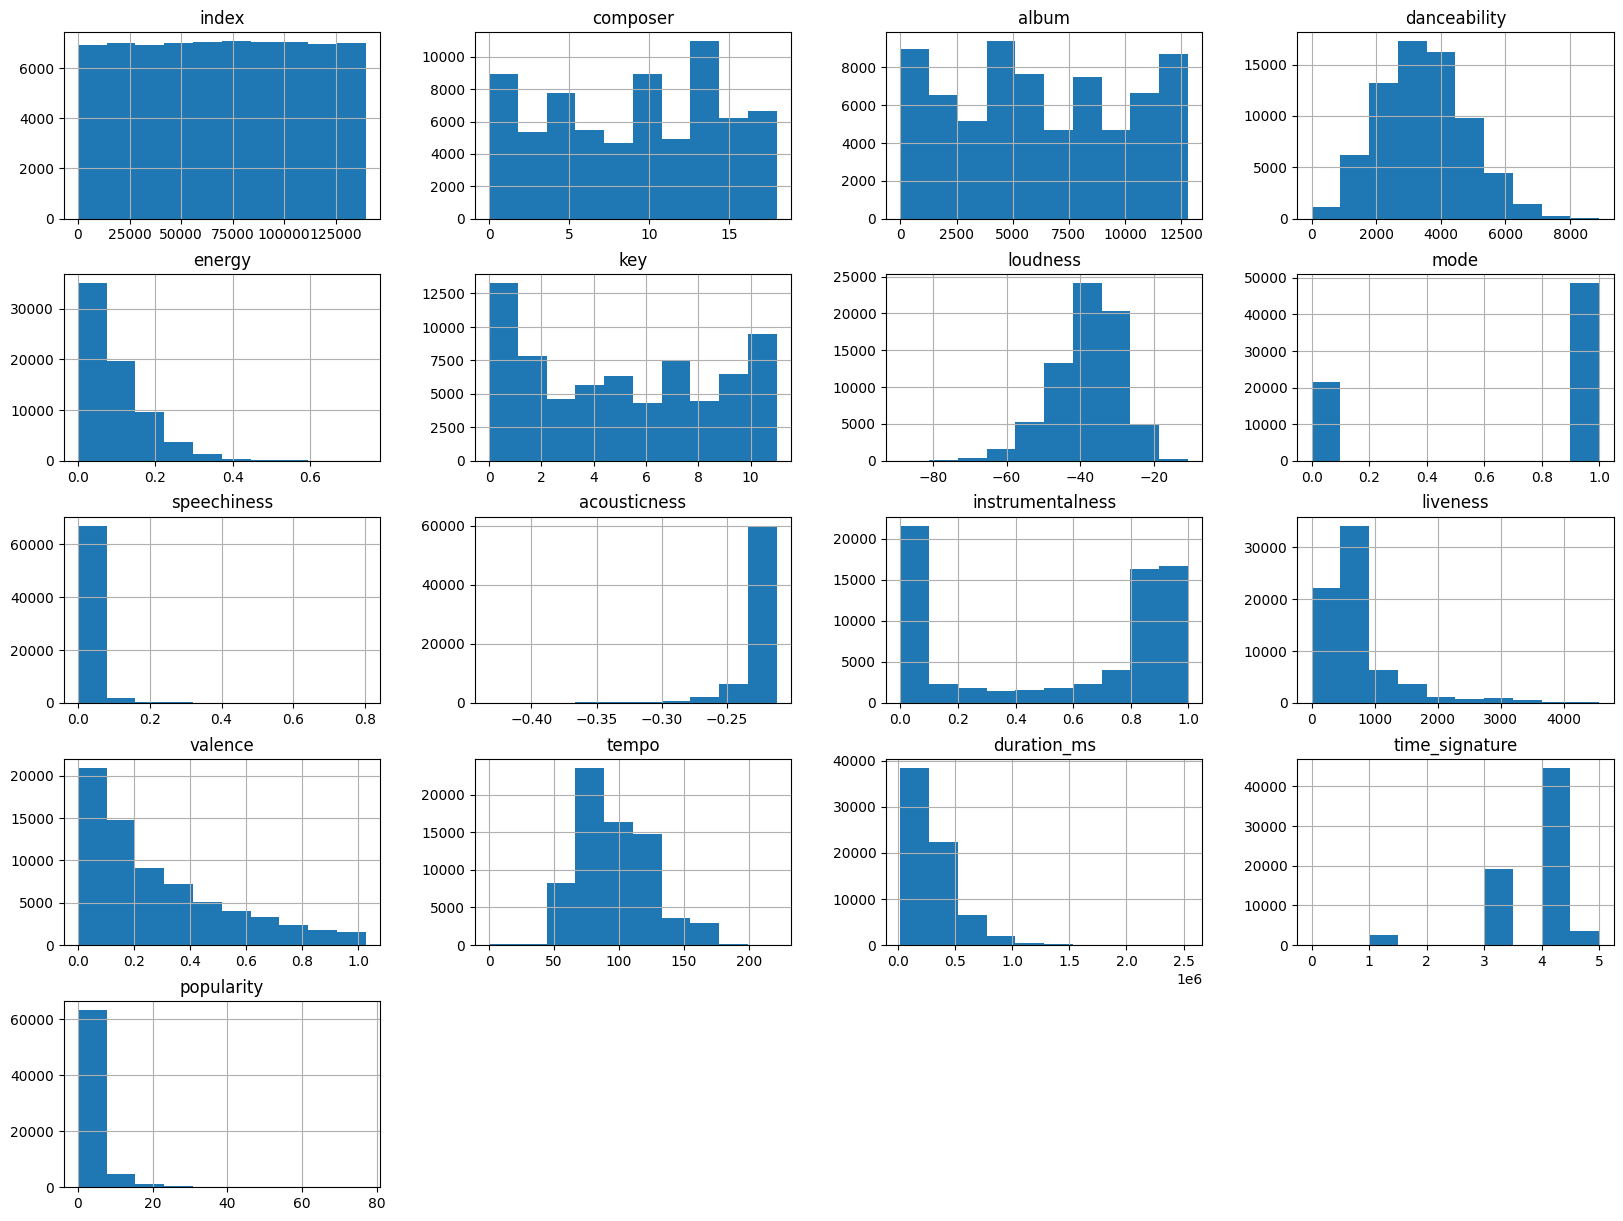

In [9]:
train.hist(figsize=(20, 15))
plt.show()

In [10]:
for col in X_train.columns:
    print(f"{col}: {X_train[col].nunique()}")

composer: 19
album: 11837
danceability: 1108
energy: 2530
key: 12
loudness: 21904
mode: 2
speechiness: 1323
acousticness: 815
instrumentalness: 5042
liveness: 1510
valence: 1630
tempo: 49052
duration_ms: 37101
time_signature: 5


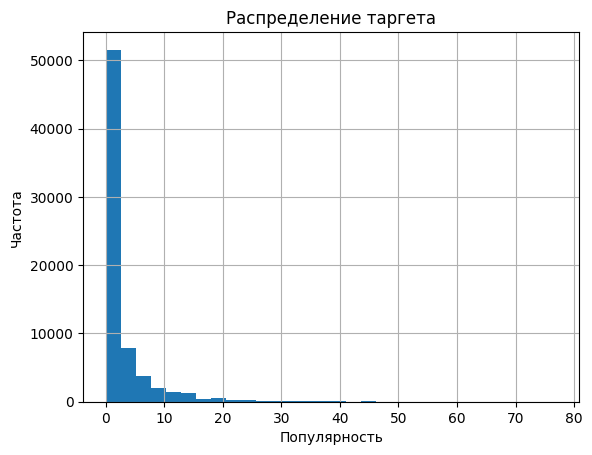

In [11]:
y_train.hist(bins=30)
plt.xlabel('Популярность')
plt.ylabel('Частота')
plt.title('Распределение таргета')
plt.show()

In [12]:
print(y_train.value_counts().sort_index())

popularity
0     25246
1     18153
2      8151
3      4760
4      3161
6      2176
7      1598
8      1155
9       888
11      772
12      609
13      473
14      440
15      368
17      326
18      219
19      204
20      180
22      120
23      133
24       98
25       83
27       77
28       65
29       67
30       64
31       42
33       38
34       30
35       30
36       30
38       34
39       25
40       18
41       19
43       21
44       17
45       15
46       11
47        9
49        9
50        7
51        6
52        6
54        9
55        6
56        4
57        1
59        4
60        4
61        2
62        3
63        2
65        3
66        1
67        2
71        1
72        3
76        1
77        1
Name: count, dtype: int64


In [13]:
print(train['popularity'].describe())
print(train['popularity'].quantile([0, 0.25, 0.5, 0.75, 1]))

count    70000.000000
mean         2.690114
std          5.166749
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         77.000000
Name: popularity, dtype: float64
0.00     0.0
0.25     0.0
0.50     1.0
0.75     3.0
1.00    77.0
Name: popularity, dtype: float64


Большинство треков имеют низкую популярность, а высокопопулярных очень мало  
Популярность - дискретная переменная с большим числом нулевых и малых значений  
Распределение похоже на экспоненциальное в основной массе малых значений  
В кросс-валидации обязательно надо будет стратифицировать по квантилям, чтобы учесть редкие "хвостовые" значения  

In [14]:
composer_counts = train['composer'].value_counts()
print(composer_counts)

composer
9     8131
13    7686
0     6721
18    5766
5     4940
16    4799
8     4643
2     3494
14    3287
7     3259
12    3157
4     2840
1     2246
6     2239
3     1853
11    1784
15    1447
17     871
10     837
Name: count, dtype: int64


In [15]:
album_counts = train['album'].value_counts()
print(album_counts.head(20))

album
5697     204
5696     121
5095     118
11188    103
7916      99
491       97
11336     97
12419     96
11970     93
11189     92
11251     92
7935      91
685       91
4464      85
4465      85
4717      82
7334      81
5715      79
11415     79
2834      77
Name: count, dtype: int64


In [16]:
composer_popularity = train.groupby('composer')['popularity'].mean().sort_values(ascending=False)
print(composer_popularity)

composer
10    4.137395
8     3.987939
0     3.687249
13    3.544106
17    3.416762
15    3.238424
18    3.104925
2     2.853463
1     2.712378
6     2.694506
3     2.473826
4     2.340141
11    2.309978
9     2.258271
7     2.161706
14    2.112260
16    1.749740
5     1.370243
12    1.197339
Name: popularity, dtype: float64


In [17]:
top_albums = album_counts.head(20).index
album_popularity = train[train['album'].isin(top_albums)].groupby('album')['popularity'].mean()
print(album_popularity)

album
491       2.546392
685       1.263736
2834      0.584416
4464      1.435294
4465      1.270588
4717      0.975610
5095      1.381356
5696      1.446281
5697      2.612745
5715      1.329114
7334      1.716049
7916      1.686869
7935      1.934066
11188    10.330097
11189     4.043478
11251     1.271739
11336     1.360825
11415     5.240506
11970     1.365591
12419     1.572917
Name: popularity, dtype: float64


Средняя популярность по альбомам и композиторам показывает различия  
Количество треков в альбоме и у композитора также сильно варьируется  
Необходимо добавить групповую информацию  

In [18]:
num_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"]
cat_features = ["composer", "album", "key", "mode", "time_signature"]

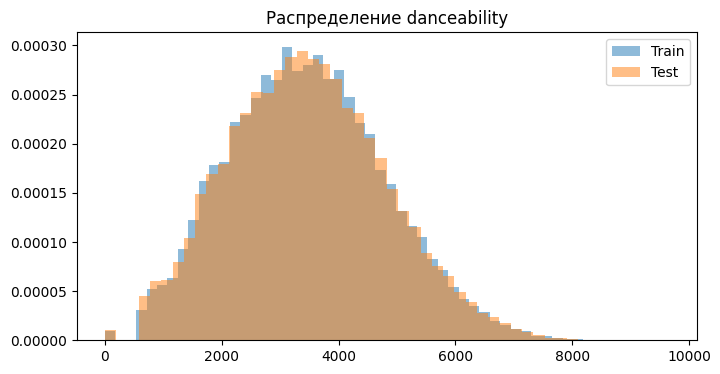

Признак: danceability
Train:
count    70000.000000
mean      3460.869327
std       1332.473130
min          0.000000
25%       2496.608000
50%       3417.488000
75%       4348.600000
max       8901.840000
Name: danceability, dtype: float64
Test:
count    69524.000000
mean      3468.956973
std       1339.341541
min          0.000000
25%       2506.840000
50%       3427.720000
75%       4369.064000
max       9648.776000
Name: danceability, dtype: float64
----------------------------------------


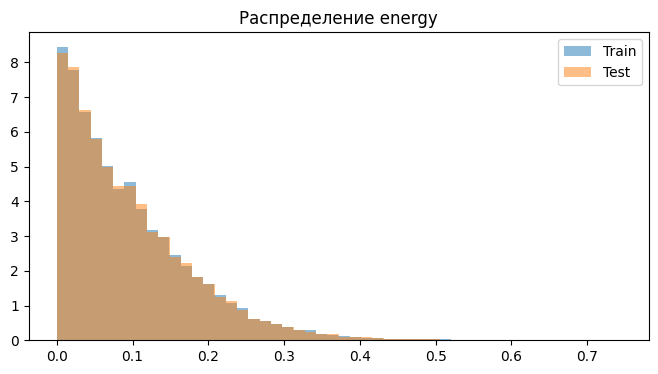

Признак: energy
Train:
count    70000.000000
mean         0.095826
std          0.083451
min          0.000100
25%          0.031025
50%          0.075144
75%          0.138384
max          0.743256
Name: energy, dtype: float64
Test:
count    69524.000000
mean         0.095588
std          0.082994
min          0.000000
25%          0.031099
50%          0.074400
75%          0.137640
max          0.744000
Name: energy, dtype: float64
----------------------------------------


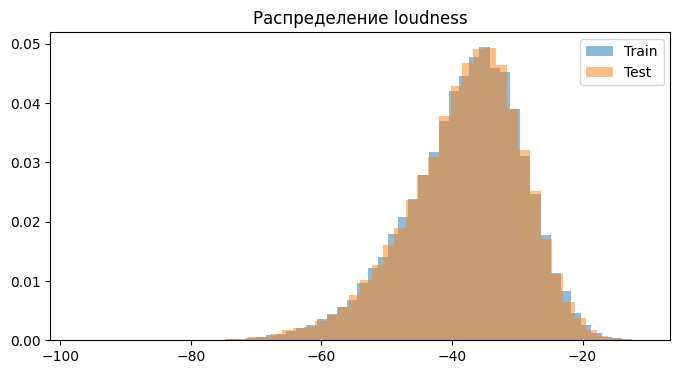

Признак: loudness
Train:
count    70000.000000
mean       -38.038053
std          8.908675
min        -88.774080
25%        -43.354650
50%        -37.038310
75%        -31.767390
max        -10.848035
Name: loudness, dtype: float64
Test:
count    69524.000000
mean       -38.034798
std          8.890045
min        -97.175000
25%        -43.303005
50%        -37.031267
75%        -31.829990
max        -10.849600
Name: loudness, dtype: float64
----------------------------------------


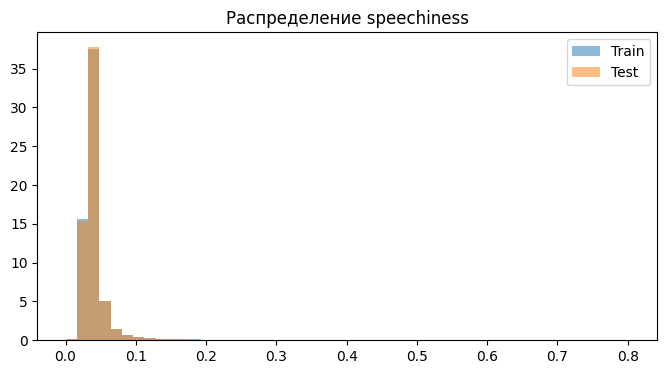

Признак: speechiness
Train:
count    70000.000000
mean         0.044565
std          0.048168
min          0.000000
25%          0.032032
50%          0.036026
75%          0.042099
max          0.801216
Name: speechiness, dtype: float64
Test:
count    69524.000000
mean         0.044215
std          0.046341
min          0.000000
25%          0.032115
50%          0.036026
75%          0.042099
max          0.802048
Name: speechiness, dtype: float64
----------------------------------------


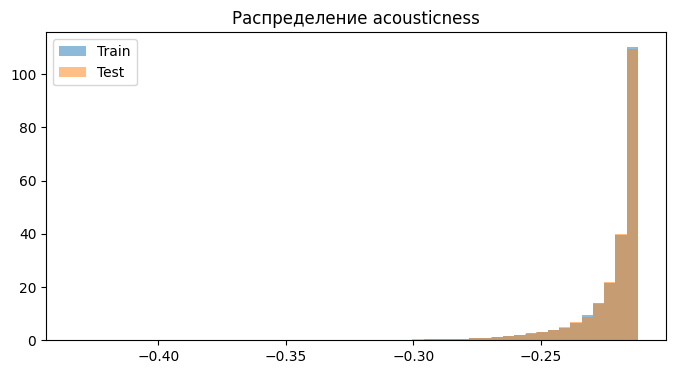

Признак: acousticness
Train:
count    70000.000000
mean        -0.223222
std          0.019497
min         -0.432312
25%         -0.224764
50%         -0.216550
75%         -0.213220
max         -0.211888
Name: acousticness, dtype: float64
Test:
count    69524.000000
mean        -0.223251
std          0.019470
min         -0.433000
25%         -0.224764
50%         -0.216550
75%         -0.213220
max         -0.211888
Name: acousticness, dtype: float64
----------------------------------------


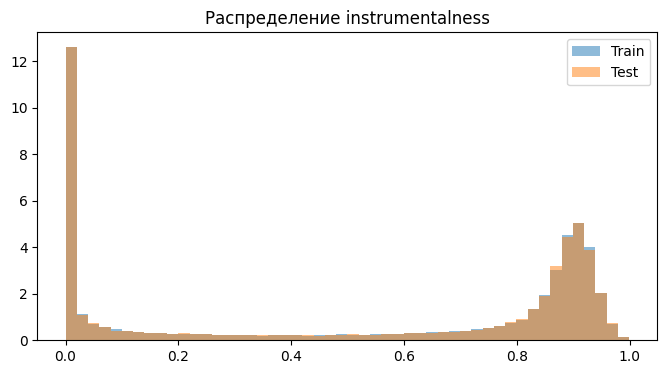

Признак: instrumentalness
Train:
count    70000.000000
mean         0.534360
std          0.398336
min          0.000000
25%          0.018700
50%          0.759000
75%          0.897000
max          0.999000
Name: instrumentalness, dtype: float64
Test:
count    69524.000000
mean         0.534145
std          0.398120
min          0.000000
25%          0.018800
50%          0.760000
75%          0.897000
max          0.999000
Name: instrumentalness, dtype: float64
----------------------------------------


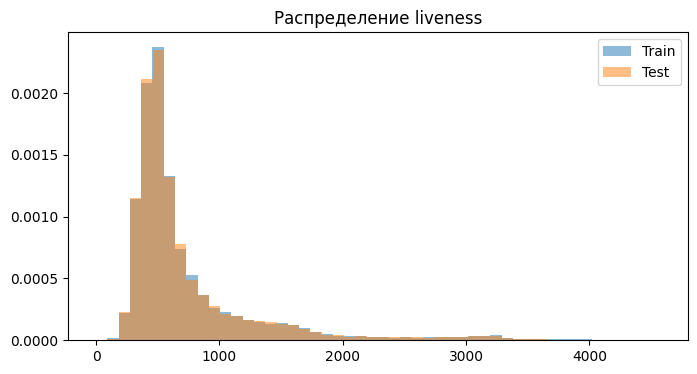

Признак: liveness
Train:
count    70000.000000
mean       738.630144
std        589.127513
min          0.000000
25%        427.702600
50%        530.556000
75%        777.218000
max       4565.574000
Name: liveness, dtype: float64
Test:
count    69524.000000
mean       733.179943
std        579.433679
min          0.000000
25%        426.306400
50%        530.556000
75%        772.564000
max       4570.228000
Name: liveness, dtype: float64
----------------------------------------


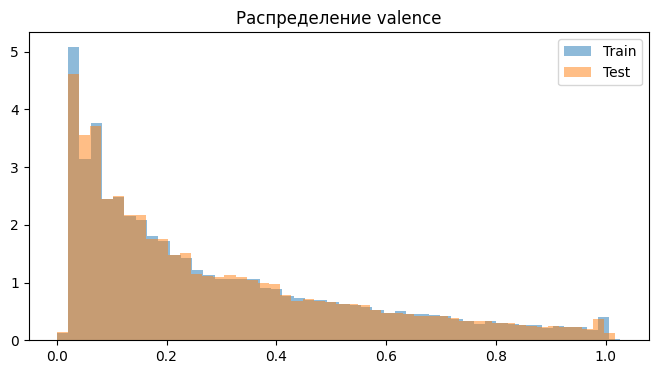

Признак: valence
Train:
count    70000.000000
mean         0.284937
std          0.246829
min          0.000000
25%          0.082400
50%          0.199820
75%          0.421270
max          1.026910
Name: valence, dtype: float64
Test:
count    69524.000000
mean         0.284351
std          0.245803
min          0.000000
25%          0.082709
50%          0.199820
75%          0.417150
max          1.017640
Name: valence, dtype: float64
----------------------------------------


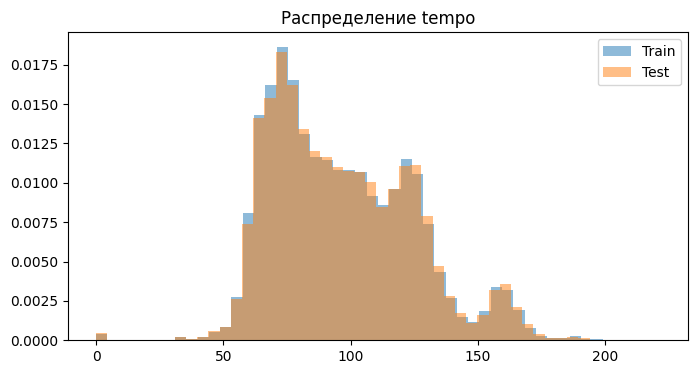

Признак: tempo
Train:
count    70000.000000
mean        96.688282
std         27.975046
min          0.000000
25%         73.941510
50%         92.230890
75%        117.299273
max        221.475780
Name: tempo, dtype: float64
Test:
count    69524.000000
mean        96.831996
std         28.042094
min          0.000000
25%         74.045438
50%         92.518260
75%        117.307643
max        220.314210
Name: tempo, dtype: float64
----------------------------------------


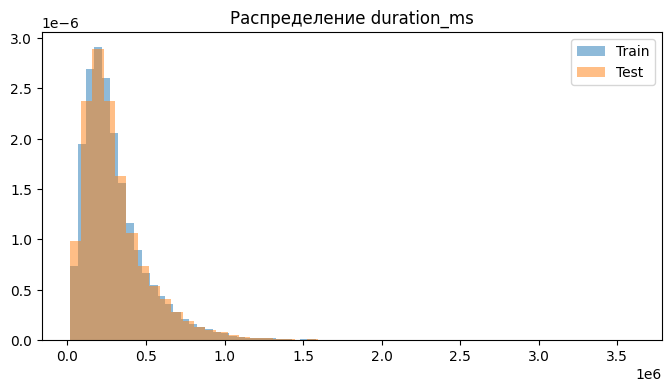

Признак: duration_ms
Train:
count    7.000000e+04
mean     3.056679e+05
std      2.120986e+05
min      1.875597e+04
25%      1.631148e+05
50%      2.506244e+05
75%      3.862059e+05
max      2.539388e+06
Name: duration_ms, dtype: float64
Test:
count    6.952400e+04
mean     3.055626e+05
std      2.140783e+05
min      1.549923e+04
25%      1.620192e+05
50%      2.499162e+05
75%      3.861504e+05
max      3.603212e+06
Name: duration_ms, dtype: float64
----------------------------------------


In [19]:
for feature in num_features:
    plt.figure(figsize=(8,4))
    plt.hist(train[feature], bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(X_test[feature], bins=50, alpha=0.5, label='Test', density=True)
    plt.title(f'Распределение {feature}')
    plt.legend()
    plt.show()

    print(f"Признак: {feature}")
    print("Train:")
    print(train[feature].describe())
    print("Test:")
    print(X_test[feature].describe())
    print("-"*40)

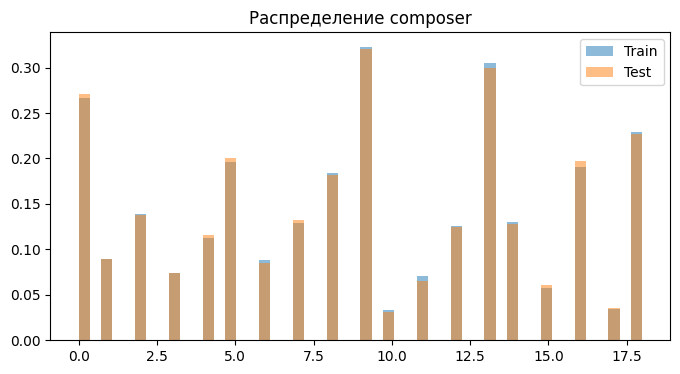

Признак: composer
Train:
count    70000.000000
mean         8.947443
std          5.561778
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         18.000000
Name: composer, dtype: float64
Test:
count    69524.000000
mean         8.923724
std          5.581838
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         18.000000
Name: composer, dtype: float64
----------------------------------------


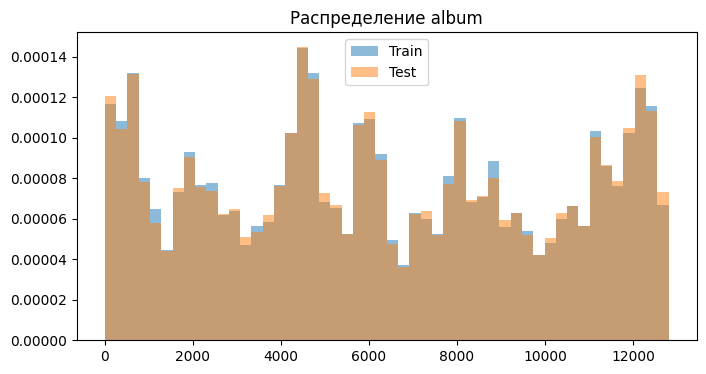

Признак: album
Train:
count    70000.000000
mean      6296.756657
std       3844.204745
min          0.000000
25%       2980.000000
50%       6039.000000
75%       9600.000000
max      12805.000000
Name: album, dtype: float64
Test:
count    69524.000000
mean      6329.969593
std       3851.759780
min          0.000000
25%       3066.000000
50%       6047.000000
75%       9679.000000
max      12805.000000
Name: album, dtype: float64
----------------------------------------


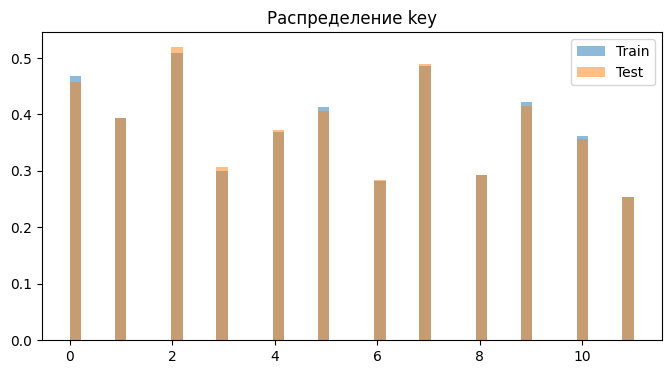

Признак: key
Train:
count    70000.000000
mean         5.162014
std          3.439068
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: key, dtype: float64
Test:
count    69524.000000
mean         5.154421
std          3.428782
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max         11.000000
Name: key, dtype: float64
----------------------------------------


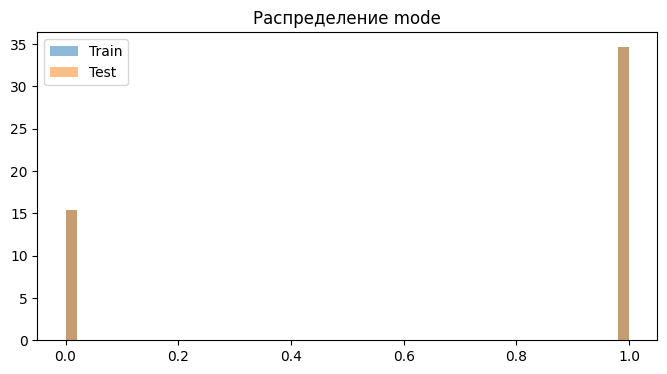

Признак: mode
Train:
count    70000.000000
mean         0.693214
std          0.461163
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: mode, dtype: float64
Test:
count    69524.000000
mean         0.692969
std          0.461266
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: mode, dtype: float64
----------------------------------------


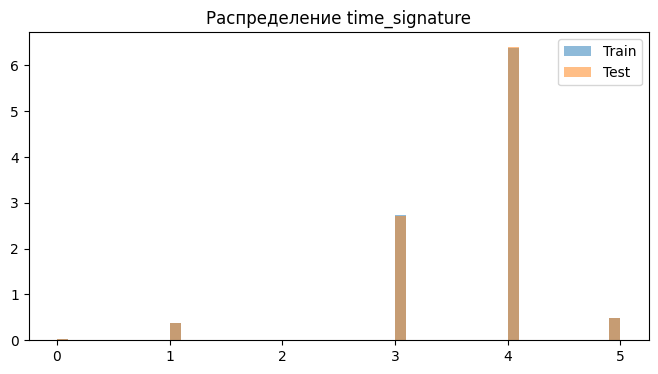

Признак: time_signature
Train:
count    70000.000000
mean         3.656857
std          0.756819
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64
Test:
count    69524.000000
mean         3.656032
std          0.757838
min          0.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64
----------------------------------------


In [20]:
for feature in cat_features:
    plt.figure(figsize=(8,4))
    plt.hist(train[feature], bins=50, alpha=0.5, label='Train', density=True)
    plt.hist(X_test[feature], bins=50, alpha=0.5, label='Test', density=True)
    plt.title(f'Распределение {feature}')
    plt.legend()
    plt.show()

    print(f"Признак: {feature}")
    print("Train:")
    print(train[feature].describe())
    print("Test:")
    print(X_test[feature].describe())
    print("-"*40)

In [21]:
for feature in num_features:
    stat, p_value = ks_2samp(train[feature], X_test[feature])
    
    print(f"{feature}: KS-statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("=> Распределения статистически значимо различаются")
    else:
        print("=> Нет статистически значимых различий")
    print("-"*40)

for feature in cat_features:
    freq_train = train[feature].value_counts().sort_index()
    freq_test = X_test[feature].value_counts().sort_index()
    
    all_categories = freq_train.index.union(freq_test.index)
    
    freq_train = freq_train.reindex(all_categories, fill_value=0)
    freq_test = freq_test.reindex(all_categories, fill_value=0)
    
    freq_train_scaled = freq_train * (freq_test.sum() / freq_train.sum())
    
    stat, p_value = chisquare(f_obs=freq_test.values, f_exp=freq_train_scaled.values)
    
    print(f"{feature}: Chi2-statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("=> Распределения категорий статистически значимо различаются")
    else:
        print("=> Нет статистически значимых различий")
    print("-"*40)

danceability: KS-statistic=0.0047, p-value=0.4117
=> Нет статистически значимых различий
----------------------------------------
energy: KS-statistic=0.0028, p-value=0.9492
=> Нет статистически значимых различий
----------------------------------------
loudness: KS-statistic=0.0041, p-value=0.5876
=> Нет статистически значимых различий
----------------------------------------
speechiness: KS-statistic=0.0028, p-value=0.9520
=> Нет статистически значимых различий
----------------------------------------
acousticness: KS-statistic=0.0035, p-value=0.7926
=> Нет статистически значимых различий
----------------------------------------
instrumentalness: KS-statistic=0.0040, p-value=0.6212
=> Нет статистически значимых различий
----------------------------------------
liveness: KS-statistic=0.0039, p-value=0.6482
=> Нет статистически значимых различий
----------------------------------------
valence: KS-statistic=0.0036, p-value=0.7598
=> Нет статистически значимых различий
-----------------

divide by zero encountered in divide


In [22]:
for feature in cat_features:
    train_values = set(train[feature].unique())
    test_values = set(X_test[feature].unique())
    new_in_test = test_values - train_values
    print(f"Признак: {feature}")
    print(f"Уникальных в train: {len(train_values)}")
    print(f"Уникальных в test: {len(test_values)}")
    print(f"Новые категории в test: {new_in_test}")
    print("-"*40)

Признак: composer
Уникальных в train: 19
Уникальных в test: 19
Новые категории в test: set()
----------------------------------------
Признак: album
Уникальных в train: 11837
Уникальных в test: 11850
Новые категории в test: {12288, 10244, 8197, 6, 8205, 10253, 2063, 12311, 2072, 8222, 6183, 10279, 2089, 2097, 51, 10291, 10293, 2104, 60, 2109, 4158, 12349, 10304, 4162, 2116, 4164, 71, 2119, 4168, 6215, 2123, 8268, 8269, 10316, 12366, 8279, 4185, 10330, 6238, 10334, 8289, 2152, 2154, 4204, 8301, 2169, 10361, 6268, 6271, 2176, 12425, 143, 144, 145, 146, 4243, 6287, 149, 6288, 10383, 10398, 161, 162, 10403, 10406, 8363, 10419, 12471, 10424, 185, 10428, 12478, 6342, 2248, 6344, 6346, 8397, 12496, 6353, 6360, 6369, 6372, 8421, 6375, 12531, 10488, 6393, 6394, 4347, 6406, 265, 2315, 10514, 2323, 276, 12565, 10518, 12568, 10521, 10523, 12572, 8480, 2341, 294, 8485, 8487, 8489, 8490, 10533, 12583, 6445, 12597, 6454, 314, 2364, 6465, 6466, 8513, 8515, 326, 10567, 328, 8520, 12621, 2383, 2392, 649

В test встречаются новые альбомы

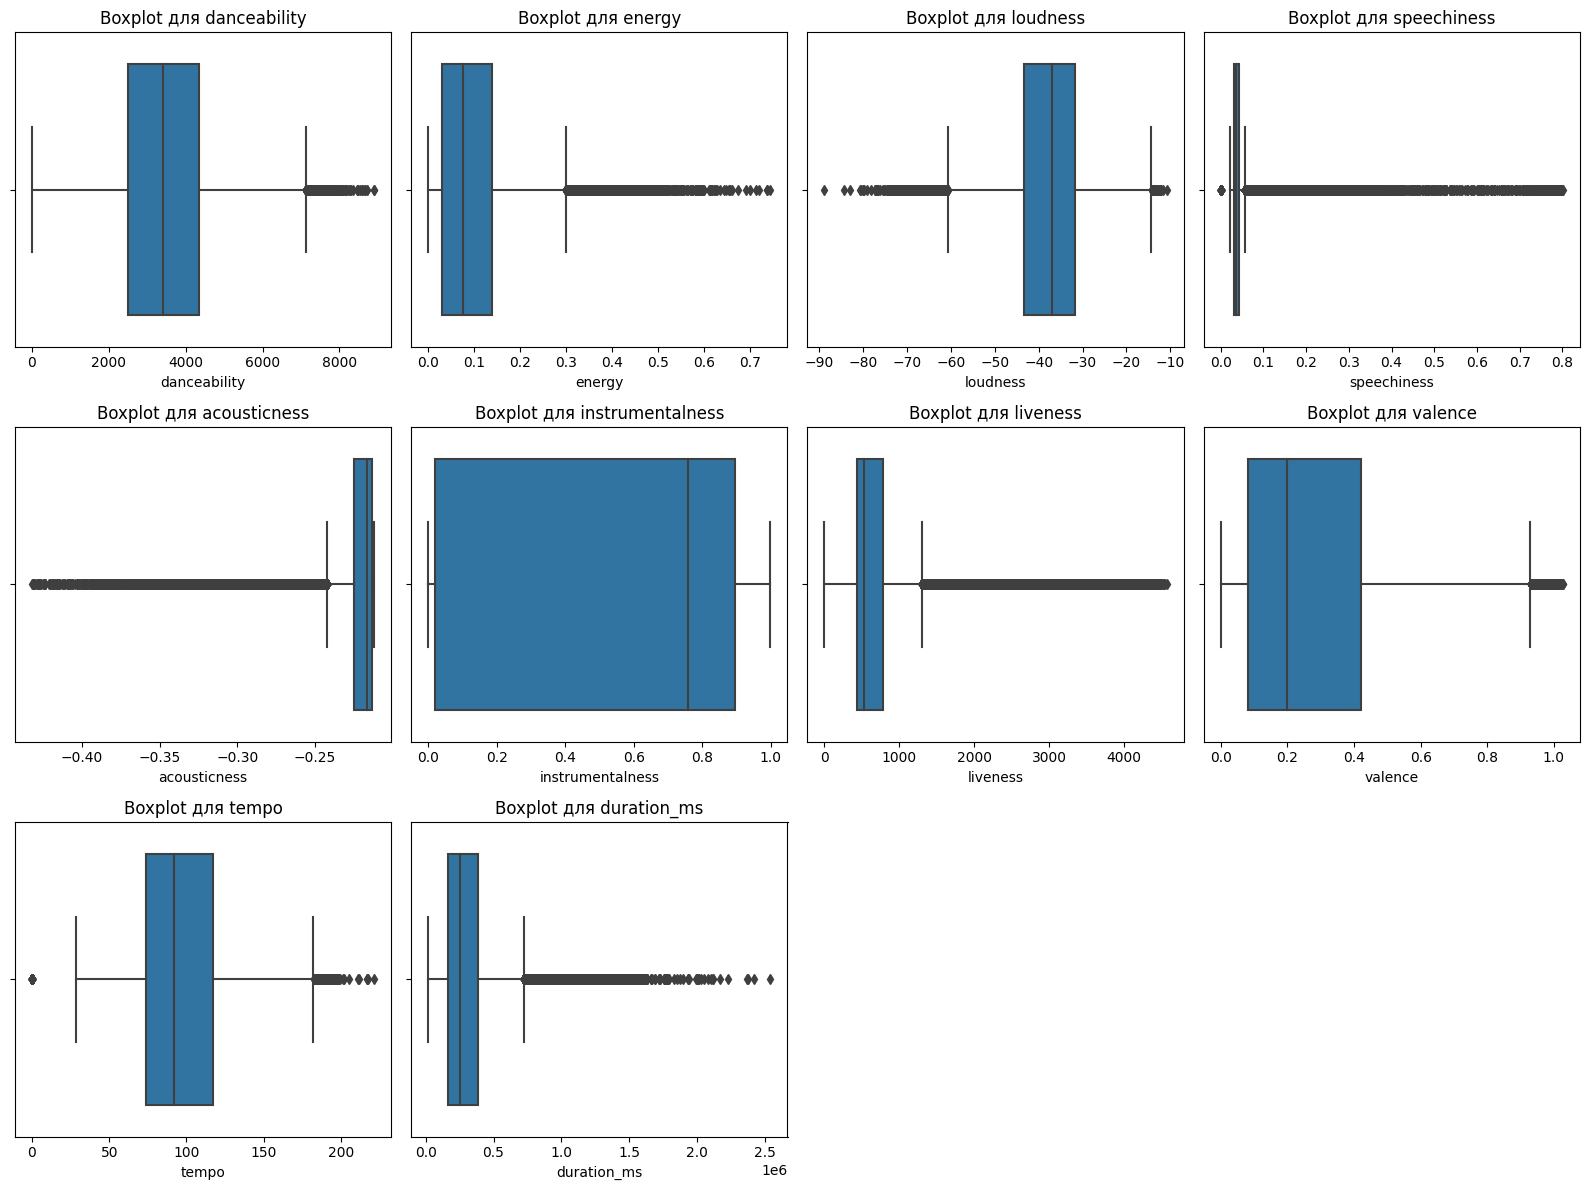

In [23]:
n_features = len(num_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.boxplot(x=train[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Много выбросов практически у всех признаков   
Необходимо прологарифмировать признаки с длинными хвостами  
Признаки с большим числом уникальных значений и выбросами можно попробовать разбить на квантили и использовать как категориальные признаки  
Рассмотреть биннинговые признаки  
Попробовать IQR-тримминг

invalid value encountered in less


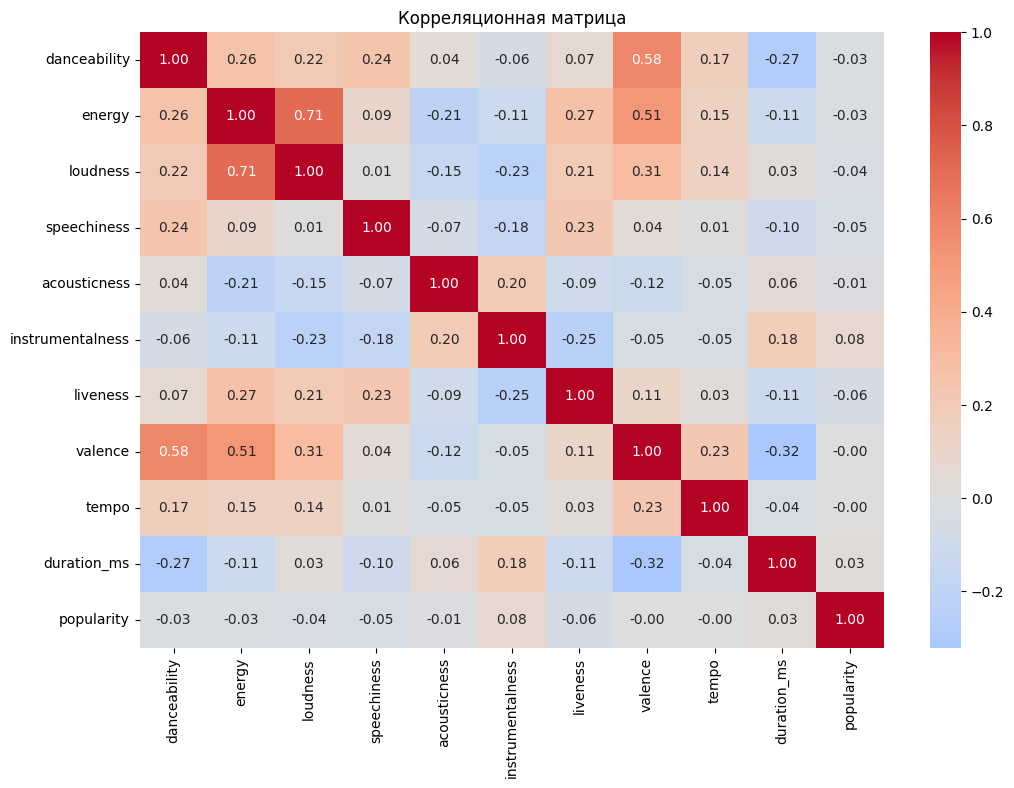

In [24]:
num_cols = num_features + ['popularity']

corr_matrix = train[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

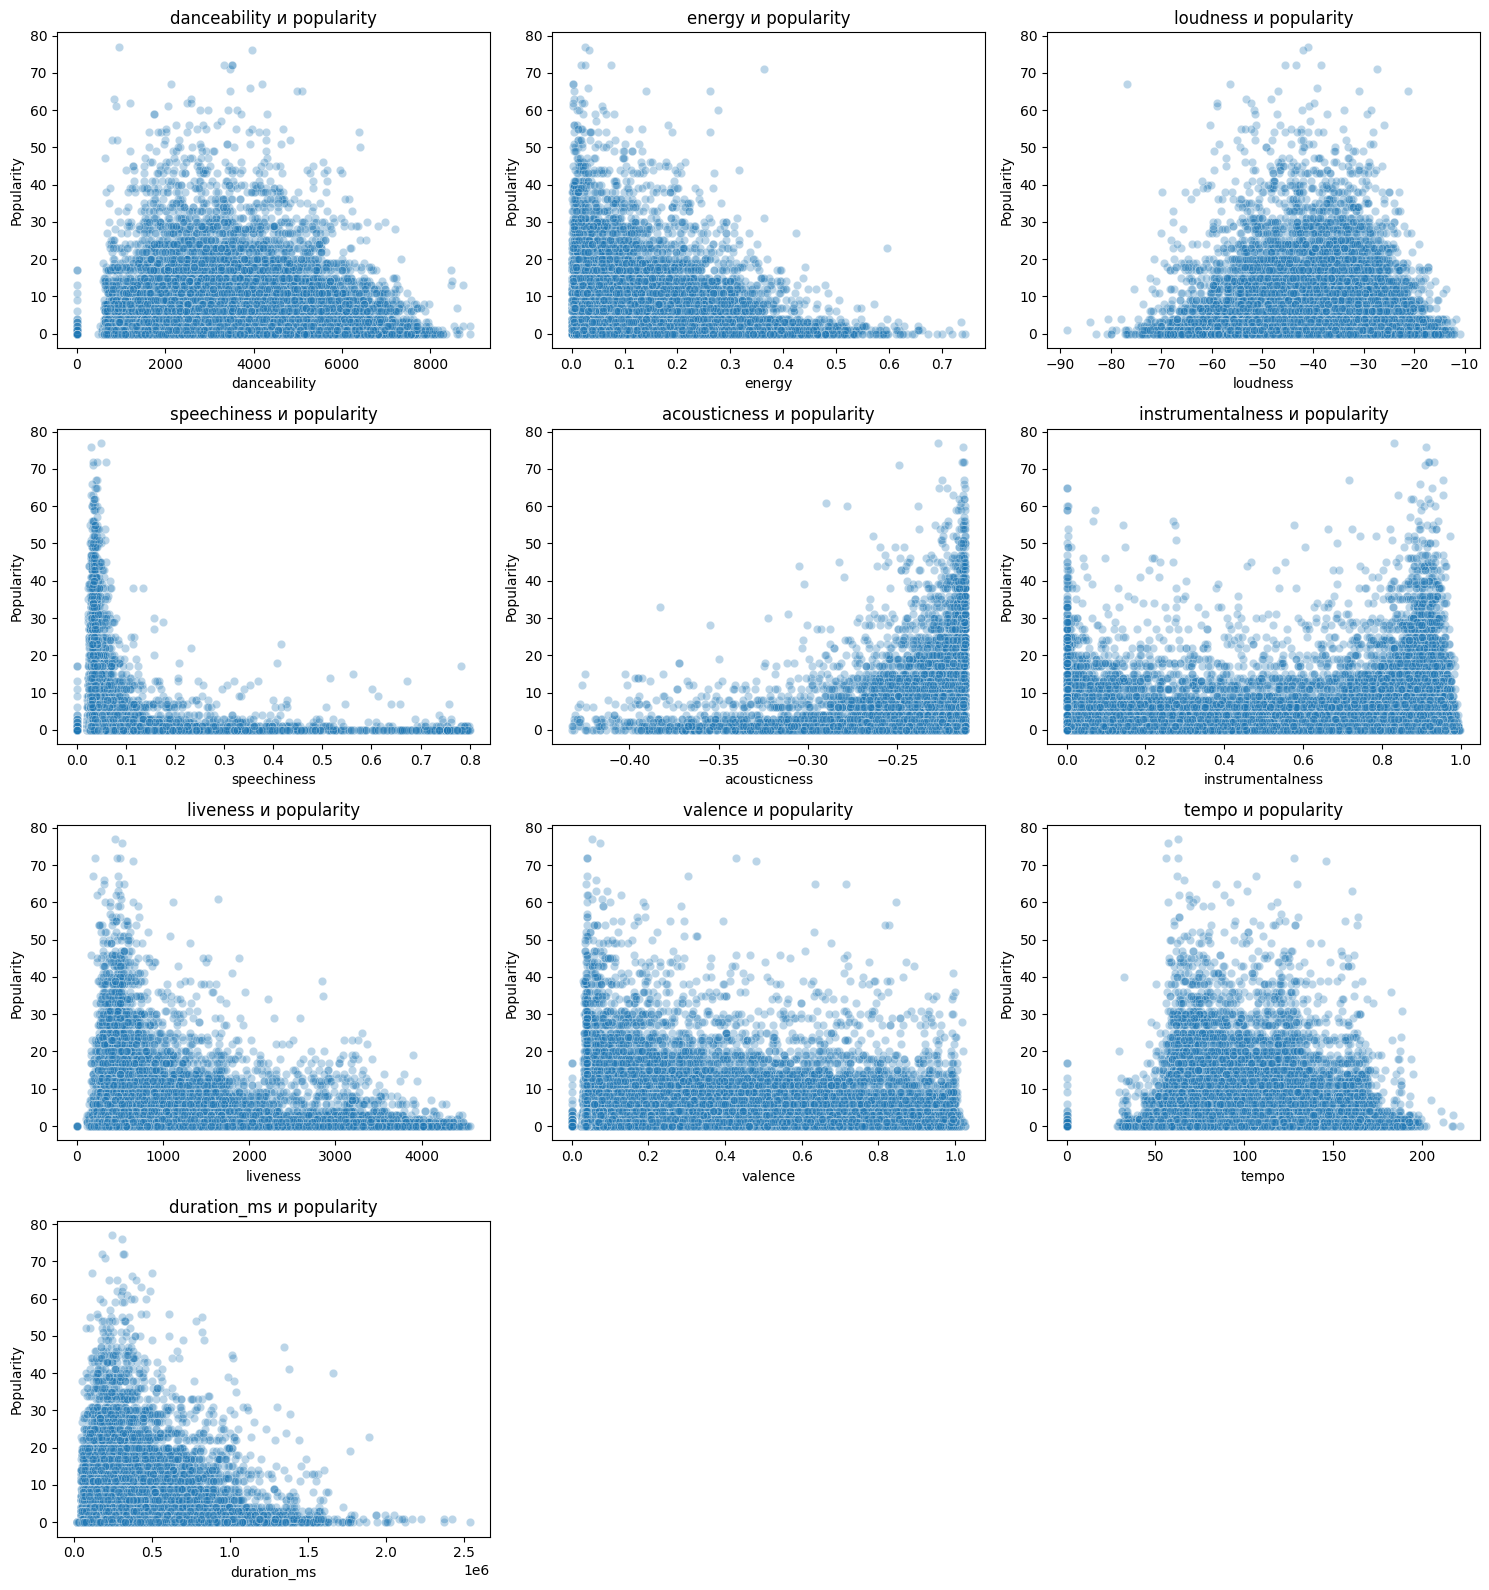

In [25]:
n_cols = 3
n_rows = (len(num_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.3, ax=axes[i])
    axes[i].set_title(f'{feature} и popularity')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Popularity')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Большинство числовых признаков имеют сложные нелинейные зависимости с таргетом  
Попробовать добавить полиномиальные признаки  

# Cross-validation  

Для начала необходим достаточно устойчивый способ сравнивать модели между собой  

In [26]:
# def create_bins(y, n_bins):
#     return pd.qcut(y, q=n_bins, labels=False, duplicates='drop')

# def run_cv(X, y, n_bins, n_splits, random_state=42):
#     y_binned = create_bins(y, n_bins)
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     rmse_scores = []
#     best_iters = []

#     cat_features = ["composer", "album", "key", "mode", "time_signature"]

#     for train_idx, val_idx in skf.split(X, y_binned):
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model = CatBoostRegressor(
#             iterations=1000,
#             depth=6,
#             learning_rate=0.05,
#             early_stopping_rounds=50,
#             cat_features=cat_features,
#             random_seed=random_state,
#             verbose=False
#         )

#         model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)

#         preds = model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, preds))
#         rmse_scores.append(rmse)
#         best_iters.append(model.get_best_iteration())

#     return {
#         'mean_rmse': np.mean(rmse_scores),
#         'std_rmse': np.std(rmse_scores),
#         'min_rmse': np.min(rmse_scores),
#         'max_rmse': np.max(rmse_scores),
#         'mean_best_iter': np.mean(best_iters),
#         'std_best_iter': np.std(best_iters),
#         'rmse_scores': rmse_scores,
#         'best_iters': best_iters
#     }

In [27]:
# bins_list = [3, 5, 7, 10]
# splits_list = [3, 5, 7, 10]
# results = []

# for n_bins in bins_list:
#     for n_splits in splits_list:
#         if n_bins <= n_splits:
#             print(f"CV: bins={n_bins}, splits={n_splits}")
#             stats = run_cv(X_train, y_train, n_bins=n_bins, n_splits=n_splits)
#             results.append({
#                 'n_bins': n_bins,
#                 'n_splits': n_splits,
#                 'mean_rmse': stats['mean_rmse'],
#                 'std_rmse': stats['std_rmse'],
#                 'min_rmse': stats['min_rmse'],
#                 'max_rmse': stats['max_rmse'],
#                 'mean_best_iter': stats['mean_best_iter'],
#                 'std_best_iter': stats['std_best_iter']
#             })

# df_results = pd.DataFrame(results)
# df_results.to_csv("cv_scheme_selection_results.csv", index=False)

In [28]:
# def repeated_cv(X, y, n_bins, n_splits, n_repeats=5):
#     rmse_all = []
#     best_iter_all = []
#     for seed in range(n_repeats):
#         stats = run_cv(X, y, n_bins=n_bins, n_splits=n_splits, random_state=seed)
#         rmse_all.extend(stats['rmse_scores'])
#         best_iter_all.extend(stats['best_iters'])
#     return {
#         'mean_rmse': np.mean(rmse_all),
#         'std_rmse': np.std(rmse_all),
#         'min_rmse': np.min(rmse_all),
#         'max_rmse': np.max(rmse_all),
#         'mean_best_iter': np.mean(best_iter_all),
#         'std_best_iter': np.std(best_iter_all),
#         'all_rmse': rmse_all,
#         'all_best_iter': best_iter_all
#     }

In [29]:
# schemes = [
#     {'n_bins': 7, 'n_splits': 7},
#     {'n_bins': 5, 'n_splits': 5},
#     {'n_bins': 3, 'n_splits': 3}
# ]

# clarification_results = []

# n_repeats = 5

# for scheme in schemes:
#     print(f"CV: bins={scheme['n_bins']}, splits={scheme['n_splits']}")
#     stats = repeated_cv(X_train, y_train, scheme['n_bins'], scheme['n_splits'], n_repeats=n_repeats)
#     clarification_results.append({
#         'n_bins': scheme['n_bins'],
#         'n_splits': scheme['n_splits'],
#         'mean_rmse': stats['mean_rmse'],
#         'std_rmse': stats['std_rmse'],
#         'min_rmse': stats['min_rmse'],
#         'max_rmse': stats['max_rmse'],
#         'mean_best_iter': stats['mean_best_iter'],
#         'std_best_iter': stats['std_best_iter']
#     })

# df_clarification = pd.DataFrame(clarification_results)
# df_clarification.to_csv("cv_scheme_selection_results_clarification.csv", index=False)

In [30]:
# def cross_validate_catboost(model, X, y, cat_features, n_splits=5, stratify_bins=5, random_state=42):
#     y_binned = pd.qcut(y, q=stratify_bins, labels=False, duplicates='drop')
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

#     rmse_scores = []

#     for train_idx, val_idx in skf.split(X, y_binned):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#         model.fit(
#             X_train, y_train,
#             cat_features=cat_features,
#             eval_set=(X_val, y_val),
#             early_stopping_rounds=50,
#             use_best_model=True,
#             verbose=False
#         )

#         preds = model.predict(X_val)

#         rmse = mean_squared_error(y_val, preds, squared=False)
#         rmse_scores.append(rmse)

#     return {
#         'mean_rmse': np.mean(rmse_scores),
#         'std_rmse': np.std(rmse_scores),
#         'rmse_scores': rmse_scores
#     }

# Baseline

За безлайн возьмем одну из самых сильных моделей со стандартными параметрами

In [31]:
# num_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                 "instrumentalness", "liveness", "valence",  "tempo", "duration_ms"]
# cat_features = ["composer", "album", "key", "mode", "time_signature",]
# groups = [['album'], ['composer'], ['album', 'composer']]

In [32]:
# model = CatBoostRegressor(
#     iterations=1000,
#     depth=6,
#     learning_rate=0.05,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

# Optimization

In [33]:
# num_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
#                 "instrumentalness", "liveness", "valence",  "tempo", "duration_ms"]
# cat_features = ["composer", "album", "key", "mode", "time_signature",]
# groups = [['album'], ['composer'], ['album', 'composer']]

# X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# def trim_outliers_iqr(df, feature):
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#     df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
#     return df

# for feature in num_features:
#     X_all = trim_outliers_iqr(X_all, feature)

# for feature in num_features:
#     min_val = X_all[feature].min()
#     shift = 0
#     if min_val <= -1:
#         shift = abs(min_val) + 1e-5
#     X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

# num_features = num_features + [f'log_{f}' for f in num_features]

# def mad(series):
#     median = series.median()
#     return np.median(np.abs(series - median))

# for group in groups:
#     group_name = '_'.join(group)
    
#     agg_df = X_all.groupby(group)[num_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
#     agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
#     agg_df = agg_df.reset_index()
    
#     mad_df = X_all.groupby(group)[num_features].agg(mad)
#     mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
#     mad_df = mad_df.reset_index()
    
#     quantiles = X_all.groupby(group)[num_features].quantile([0.25, 0.75]).unstack(level=-1)
#     quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
#     quantiles = quantiles.reset_index()
    
#     for feature in num_features:
#         q25 = f'{group_name}_{feature}_q25'
#         q75 = f'{group_name}_{feature}_q75'
#         quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
#     count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
#     agg_df = agg_df.merge(mad_df, on=group, how='left')
#     agg_df = agg_df.merge(quantiles, on=group, how='left')
#     agg_df = agg_df.merge(count_df, on=group, how='left')
    
#     X_all = X_all.merge(agg_df, on=group, how='left')

# X_train_agg = X_all.iloc[:len(X_train)].copy()
# X_test_agg = X_all.iloc[len(X_train):].copy()

In [34]:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2500),
#         'depth': trial.suggest_int('depth', 4, 8),
#         'random_seed': 42,
#         'verbose': False
#     }
    
#     model = CatBoostRegressor(**params)
    
#     cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)
    
#     return cv_results['mean_rmse']

# max_jobs = os.cpu_count() 
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, n_jobs=max_jobs)

# print("Лучшие параметры:", study.best_params)
# print(f"Лучшее среднее RMSE: {study.best_value:.4f}")

In [35]:
# model = CatBoostRegressor(
#     iterations=1500,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [36]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# cv_results = cross_validate_catboost(model, X_train_agg, y_train, cat_features)

# print(f"RMSE: {cv_results['mean_rmse']:.4f}")
# print(f"RMSE std: {cv_results['std_rmse']:.4f}")

In [37]:
# X_train_628 = X_train_agg.copy()
# X_test_628 = X_test_agg.copy()
# all_features_628 = X_train_628.columns.tolist()
# cat_features_628 = ["composer", "album", "key", "mode", "time_signature"]
# num_features_628 = [f for f in all_features_628 if f not in cat_features_628]

# print(len(all_features_628))
# print(len(num_features_628))
# print(len(X_train_628))
# print(len(X_test_628))

# data_to_save = {
#     'X_train': X_train_628,
#     'X_test': X_test_628,
#     'cat_features': cat_features_628,
#     'num_features': num_features_628
# }

# with open('catboost_628.pkl', 'wb') as f:
#     pickle.dump(data_to_save, f)

# Feature Selection

In [38]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# model.fit(
#     X_train_628, y_train,
#     cat_features=cat_features_628,
#     verbose=False
# )

In [39]:
# num_features = X_train_agg.shape[1]
# print(f"Количество признаков: {num_features}")

# feature_importances = model.get_feature_importance()
# feature_names = X_train_agg.columns

# fi_df = pd.DataFrame({
#     'feature': feature_names,
#     'importance': feature_importances
# }).sort_values(by='importance', ascending=False)

# fi_df = fi_df.reset_index(drop=True)
# fi_df.index = fi_df.index + 1

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# print(f"Наиболее важные в рамках catboost:")
# print(fi_df)

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [40]:
# sample = X_train_agg.sample(5000, random_state=42)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(sample)

# mean_abs_shap = np.abs(shap_values).mean(axis=0)
# top_indices = np.argsort(mean_abs_shap)[-30:]
# top_features = sample.columns[top_indices]

# shap.summary_plot(shap_values[:, top_indices], sample[top_features], max_display=30)

In [41]:
# top_200_features = fi_df.head(200)['feature'].tolist()
# print(f"Выбрано признаков: {len(top_200_features)}")

# X_train_top_200 = X_train_628[top_200_features].copy()
# X_test_top_200 = X_test_628[top_200_features].copy()

# cat_features_top_200 = [f for f in cat_features_628 if f in top_200_features]
# num_features_top_200 = [f for f in top_200_features if f not in cat_features_top_200]

# print(f"Категориальных признаков среди топ-200: {len(cat_features_top_200)}")
# print(f"Числовых признаков среди топ-200: {len(num_features_top_200)}")

# data_to_save_top_200 = {
#     'X_train': X_train_top_200,
#     'X_test': X_test_top_200,
#     'cat_features': cat_features_top_200,
#     'num_features': num_features_top_200
# }

# with open('catboost_top_200.pkl', 'wb') as f:
#     pickle.dump(data_to_save_top_200, f)

# Catboost

In [42]:
num_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
                "instrumentalness", "liveness", "valence",  "tempo", "duration_ms"]
cat_features = ["composer", "album", "key", "mode", "time_signature",]
groups = [['album'], ['composer'], ['album', 'composer']]

X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

def trim_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
    return df

for feature in num_features:
    X_all = trim_outliers_iqr(X_all, feature)

for feature in num_features:
    min_val = X_all[feature].min()
    shift = 0
    if min_val <= -1:
        shift = abs(min_val) + 1e-5
    X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

num_features = num_features + [f'log_{f}' for f in num_features]

def mad(series):
    median = series.median()
    return np.median(np.abs(series - median))

for group in groups:
    group_name = '_'.join(group)
    
    agg_df = X_all.groupby(group)[num_features].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
    agg_df = agg_df.reset_index()
    
    mad_df = X_all.groupby(group)[num_features].agg(mad)
    mad_df.columns = [f'{group_name}_{col}_mad' for col in mad_df.columns]
    mad_df = mad_df.reset_index()
    
    quantiles = X_all.groupby(group)[num_features].quantile([0.25, 0.75]).unstack(level=-1)
    quantiles.columns = [f'{group_name}_{col}_q{int(q*100)}' for col, q in quantiles.columns]
    quantiles = quantiles.reset_index()
    
    for feature in num_features:
        q25 = f'{group_name}_{feature}_q25'
        q75 = f'{group_name}_{feature}_q75'
        quantiles[f'{group_name}_{feature}_iqr'] = quantiles[q75] - quantiles[q25]
    
    count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    
    agg_df = agg_df.merge(mad_df, on=group, how='left')
    agg_df = agg_df.merge(quantiles, on=group, how='left')
    agg_df = agg_df.merge(count_df, on=group, how='left')
    
    X_all = X_all.merge(agg_df, on=group, how='left')

X_train_628 = X_all.iloc[:len(X_train)].copy()
X_test_628 = X_all.iloc[len(X_train):].copy()
all_features_628 = X_train_628.columns.tolist()
cat_features_628 = ["composer", "album", "key", "mode", "time_signature"]
num_features_628 = [f for f in all_features_628 if f not in cat_features_628]

print(len(all_features_628))
print(len(num_features_628))
print(len(X_train_628))
print(len(X_test_628))

data_to_save = {
    'X_train': X_train_628,
    'X_test': X_test_628,
    'cat_features': cat_features_628,
    'num_features': num_features_628
}

with open('catboost_628.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

628
623
70000
69524


In [43]:
model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=False
)

model.fit(
    X_train_628, y_train,
    cat_features=cat_features_628,
    verbose=False
)

In [44]:
num_features = X_train_628.shape[1]
print(f"Количество признаков: {num_features}")

feature_importances = model.get_feature_importance()
feature_names = X_train_628.columns

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# fi_df = fi_df.reset_index(drop=True)
# fi_df.index = fi_df.index + 1

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# print(f"Наиболее важные в рамках catboost:")
# print(fi_df)

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

top_200_features = fi_df.head(200)['feature'].tolist()
print(f"Выбрано признаков: {len(top_200_features)}")

X_train_top_200 = X_train_628[top_200_features].copy()
X_test_top_200 = X_test_628[top_200_features].copy()

cat_features_top_200 = [f for f in cat_features_628 if f in top_200_features]
num_features_top_200 = [f for f in top_200_features if f not in cat_features_top_200]

print(f"Категориальных признаков среди топ-200: {len(cat_features_top_200)}")
print(f"Числовых признаков среди топ-200: {len(num_features_top_200)}")

data_to_save = {
    'X_train': X_train_top_200,
    'X_test': X_test_top_200,
    'cat_features': cat_features_top_200,
    'num_features': num_features_top_200
}

with open('catboost_top_200.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

Количество признаков: 628
Выбрано признаков: 200
Категориальных признаков среди топ-200: 3
Числовых признаков среди топ-200: 197


In [45]:
# model = CatBoostRegressor(
#     iterations=2000,
#     depth=6,
#     learning_rate=0.05,
#     early_stopping_rounds=50,
#     random_seed=42,
#     verbose=False
# )

# model.fit(
#     X_train_top_200, y_train,
#     cat_features=cat_features_top_200,
#     verbose=False
# )

In [46]:
# test_preds = model.predict(X_test_top_200)
# test_preds = [max(0, pred) for pred in test_preds]

# submission = pd.DataFrame({
#     "index": test["index"],
#     "popularity": test_preds
# })

# submission.to_csv("/kaggle/working/submission.csv", index=False)

# Random forest

Для категориальных признаков применим таргетное кодирование

In [47]:
num_features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
                "instrumentalness", "liveness", "valence",  "tempo", "duration_ms"]
cat_features = ["composer", "album", "key", "mode", "time_signature",]
groups = [['album'], ['composer'], ['album', 'composer']]

X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

def trim_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])
    return df

for feature in num_features:
    X_all = trim_outliers_iqr(X_all, feature)

for feature in num_features:
    min_val = X_all[feature].min()
    shift = 0
    if min_val <= -1:
        shift = abs(min_val) + 1e-5
    X_all[f'log_{feature}'] = np.log1p(X_all[feature] + shift)

num_features_all = num_features + [f'log_{f}' for f in num_features]

for group in groups:
    group_name = '_'.join(group)
    
    agg_df = X_all.groupby(group)[num_features_all].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    agg_df.columns = [f'{group_name}_{col}_{agg}' for col, agg in agg_df.columns]
    agg_df = agg_df.reset_index()
    
    count_df = X_all.groupby(group).size().reset_index(name=f'{group_name}_count')
    agg_df = agg_df.merge(count_df, on=group, how='left')
    
    X_all = X_all.merge(agg_df, on=group, how='left')

X_train_agg = X_all.iloc[:len(X_train)].copy()
X_test_agg = X_all.iloc[len(X_train):].copy()

def target_encode_album_composer(train_df, target, test_df):
    train_tmp = train_df.copy()
    train_tmp['target'] = target.values

    agg_pair = train_tmp.groupby(['album', 'composer'])['target'].mean().reset_index()
    mapping_pair = agg_pair.set_index(['album', 'composer'])['target'].to_dict()

    agg_composer = train_tmp.groupby('composer')['target'].mean().reset_index()
    mapping_composer = agg_composer.set_index('composer')['target'].to_dict()

    global_mean = target.mean()

    def map_pair(row):
        key = (row['album'], row['composer'])
        if key in mapping_pair:
            return mapping_pair[key]
        elif row['composer'] in mapping_composer:
            return mapping_composer[row['composer']]
        else:
            return global_mean

    train_encoded = train_df.copy()
    train_encoded['album_composer_te'] = train_encoded.apply(map_pair, axis=1)

    test_encoded = test_df.copy()
    test_encoded['album_composer_te'] = test_encoded.apply(map_pair, axis=1)

    return train_encoded, test_encoded

X_train_agg_TE, X_test_agg_TE = target_encode_album_composer(X_train_agg, y_train, X_test_agg)

cat_features = [c for c in cat_features if c not in ['composer', 'album']]

X_train_agg_TE = X_train_agg_TE.drop(columns=['album', 'composer'])
X_test_agg_TE = X_test_agg_TE.drop(columns=['album', 'composer'])

def bin_target(y, n_bins=5):
    y_binned = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
    return y_binned

def target_encode_cv_stratified(train_df, target, cat_cols, n_splits=5, n_bins=5):
    train_encoded = train_df.copy()
    global_mean = target.mean()
    
    y_binned = bin_target(target, n_bins)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for col in cat_cols:
        oof = pd.Series(index=train_df.index, dtype=float)
        
        for train_idx, val_idx in skf.split(train_df, y_binned):
            means = target.iloc[train_idx].groupby(train_df.iloc[train_idx][col]).mean()
            oof.iloc[val_idx] = train_df.iloc[val_idx][col].map(means)
        
        oof.fillna(global_mean, inplace=True)
        train_encoded[f'{col}_te'] = oof
        
    return train_encoded

def target_encode_test(train_series, target, test_series):
    global_mean = target.mean()
    means = target.groupby(train_series).mean()
    return test_series.map(means).fillna(global_mean)

other_cat_features = ['time_signature', 'key', 'mode']

X_train_agg_TE = target_encode_cv_stratified(X_train_agg_TE, y_train, other_cat_features, n_splits=5, n_bins=5)

X_test_agg_TE = X_test_agg_TE.copy()
for col in other_cat_features:
    X_test_agg_TE[f'{col}_te'] = target_encode_test(X_train_agg_TE[col], y_train, X_test_agg_TE[col])

X_train_agg_TE = X_train_agg_TE.drop(columns=other_cat_features)
X_test_agg_TE = X_test_agg_TE.drop(columns=other_cat_features)

X_train_agg_TE = X_train_agg_TE.fillna(0)
X_test_agg_TE = X_test_agg_TE.fillna(0)

In [48]:
X_train_RF_387 = X_train_agg_TE.copy()
X_test_RF_387 = X_test_agg_TE.copy()
num_features_RF_387 = X_train_agg_TE.columns.tolist()

print(len(X_train_RF_387))
print(len(X_test_RF_387))
print(len(num_features_RF_387))

data_to_save = {
    'X_train': X_train_RF_387,
    'X_test': X_test_RF_387,
    'num_features': num_features_RF_387
}

with open('random_forest_387.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

70000
69524
387


In [49]:
# rf_model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1
# )

# rf_model.fit(X_train_RF_387, y_train)

In [50]:
# test_preds = rf_model.predict(X_test_RF_387)
# test_preds = [max(0, pred) for pred in test_preds]

# submission = pd.DataFrame({
#     "index": test["index"],
#     "popularity": test_preds
# })

# submission.to_csv("/kaggle/working/submission.csv", index=False)

# Stacking

In [51]:
y_train_log = np.log1p(y_train)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds_rf = np.zeros(len(X_train_RF_387))
oof_preds_cb = np.zeros(len(X_train_top_200))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_RF_387)):
    print(f"Fold {fold+1}")

    X_tr_rf, X_val_rf = X_train_RF_387.iloc[train_idx], X_train_RF_387.iloc[val_idx]
    y_tr_log, y_val_log = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    rf_fold = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42,
        n_jobs=-1)
    
    rf_fold.fit(X_tr_rf, y_tr_log)
    oof_preds_rf[val_idx] = np.expm1(rf_fold.predict(X_val_rf))

    X_tr_cb, X_val_cb = X_train_top_200.iloc[train_idx], X_train_top_200.iloc[val_idx]

    cb_fold = CatBoostRegressor(
        iterations=2000,
        depth=6,
        learning_rate=0.05,
        early_stopping_rounds=50,
        random_seed=42,
        verbose=False
    )
    
    cb_fold.fit(
        X_tr_cb, y_tr_log,
        cat_features=cat_features_top_200,
        eval_set=(X_val_cb, y_val_log),
        use_best_model=True,
        verbose=False
    )
    
    oof_preds_cb[val_idx] = np.expm1(cb_fold.predict(X_val_cb))

stacked_train = pd.DataFrame({'rf_pred': oof_preds_rf, 'cb_pred': oof_preds_cb})

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [52]:
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

LinearRegression()

In [53]:
rf_full = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,
    random_state=42, 
    n_jobs=-1)

rf_full.fit(X_train_RF_387, y_train_log)

cb_full = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=False
)

cb_full.fit(
    X_train_top_200, y_train_log,
    cat_features=cat_features_top_200,
    verbose=False
)

In [54]:
test_preds_rf_full = np.expm1(rf_full.predict(X_test_RF_387))
test_preds_cb_full = np.expm1(cb_full.predict(X_test_top_200))

stacked_test_full = pd.DataFrame({
    'rf_pred': test_preds_rf_full,
    'cb_pred': test_preds_cb_full
})

final_test_preds = meta_model.predict(stacked_test_full)
final_test_preds = [max(0, pred) for pred in final_test_preds]

submission = pd.DataFrame({
    "index": test["index"],
    "popularity": final_test_preds
})

submission.to_csv("/kaggle/working/submission.csv", index=False)